In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import the data into a Pandas dataframe however you wish and take a look at the data. 

In [40]:
df = pd.read_csv('ngozumpa-depressions_2019.csv', index_col = [0])
df

,area,perimeter,depth
0,21,40,0.15
1,10,22,0.24
2,56,56,0.69
3,193,114,0.96
4,672,216,4.69
...,...,...,...
31319,211,130,1.15
31320,181,76,3.34
31321,461,168,2.80
31322,282,146,2.13


## It's a good idea to get a general idea of the general statistics of the data. What do you notice about these statistics? 

In [41]:
df.describe()

,area,perimeter,depth
count,31324.000000,31324.000000,31324.000000
mean,63.447069,13.547025,0.220654
std,2319.680208,140.879211,0.735109
min,1.000000,4.000000,0.000000
25%,1.000000,4.000000,0.030000
50%,1.000000,4.000000,0.070000
75%,3.000000,8.000000,0.170000
max,251241.000000,18793.000000,38.960000


## These data were calculated from a 1 meter resolution DEM. Therefore, it is unlikely that depressions ~1 meter represent actual features in the topography. Instead, these small depressions probably arise from noise in the data. Let's eliminate all the depressions smaller than 10 m$^2$ from the data frame. 

In [42]:
df = df[df['area'] >= 10]

## Histograms are a quick and easy way to look at how the data are distributed. Let's look at a histogram of depression areas. What do you notice about the data? 

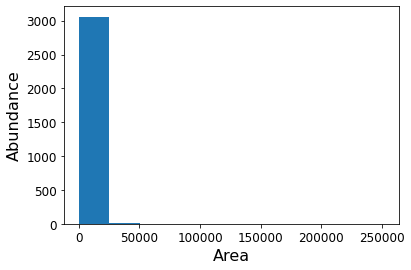

In [43]:
plt.hist(df.area)
plt.xlabel('Area', fontsize = 16)
plt.ylabel('Abundance', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

## Looking back at the basic statistics, we see that the depression areas span more than 5 orders of magnitude. This is a good sign that we need to transform our data into log space. 

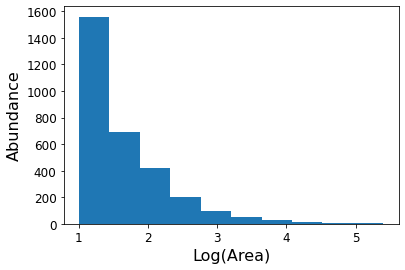

In [44]:
plt.hist(np.log10(df.area))
plt.xlabel('Log(Area)', fontsize = 16)
plt.ylabel('Abundance', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

## Transforming the areas into log-space looks much nicer. Notice that the most abundant bin size (smallest depressions) has more than 1500 depressions in it, while the largest bin has very few depressions. Let's transform the number of depressions in each bin into log space as well. Now we have a histogram of depression areas in log-log space. 

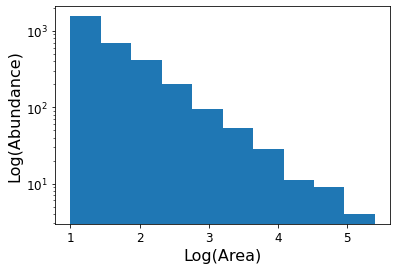

In [45]:
plt.hist(np.log10(df.area), log = True)
plt.xlabel('Log(Area)', fontsize = 16)
plt.ylabel('Log(Abundance)', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

## This histogram looks linear in log-log space. That is strongly suggestive of a power law distribution. Histograms are not the best way to visualize power law distributions. Instead, we should try to create the cumulative probability density function. 

## $$\overline{F}(a) = P(a < a_{max})$$

## All this function is saying is we want to calculate the probability that a depression of size $a$ is smaller than the largest depression $a_{max}$. 

## Based on the histograms, we should expect this probability distribution to be a decreasing function. I.e., as depressions grow larger, the chance they're smaller than the biggest one should decrease. 

In [46]:
#Define a function to calculate the probability distribution
def normed_CPD(data):
    #Lets sort the data from smallest to largest
    data = np.sort(data)
    
    #Probability is just the number of outcomes we are interested in
    #divided by the total number of possible outcomes
    
    #Let's create an array that stores the number of outcomes
    # data[i] is the value we're interested in
    # data is all the remaining values
    # (data[i] < data).sum() counts the number of data points larger than data[i]
    # for i in range(len(data)) repeats this calculation for all the possible data values
    prob = [(data[i] < data).sum() for i in range(len(data))]
    
    #Finally, we calculate the probability by dividing by the maximum number of outcomes
    return prob / max(prob)

## Now let's calculate the cumulative probability distribution and plot in log-log space.

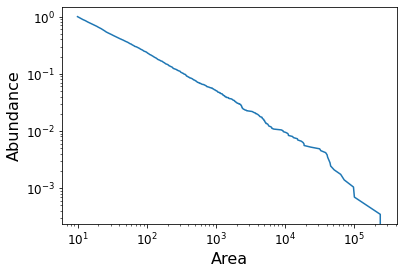

In [48]:
plt.loglog(np.sort(df['area']), normed_CPD(df['area']))
plt.xlabel('Area', fontsize = 16)
plt.ylabel('Abundance', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

## This distribution looks remarkably linear in log-log space. Our confidence should be growing that these data may be power law distributed.

## It is not straightforward to calculate the slope of a probability distribution in log-log space using the least-squares regression method. Instead, we need to turn to the mathematicians to tell us what to do. 

## Newman et al. (2005) present an easy way to calculate the scaling exponent, based on some rigorous statistics that we will not go into here. 

## $$ \alpha = 1 + n \left[ \sum_{i=1}^{n} \frac {x_i}{x_{min}} \right]^{-1} $$

## This may look scary, but it's pretty easy to code up. 

In [50]:
#Our code will be easier to understand if we define a function to do this for us
def calc_alpha(data, low_cutoff = None, high_cutoff = None):
    #Let's sort the data 
    data = np.sort(data)
    
    #These are checkpoints that choose values for parameters in case the user does not specify 
    if high_cutoff == None:
        high_cutoff = max(data)
    if low_cutoff == None:
        low_cutoff = min(data)
        
    #We trim the data to just look at the range of values in which we are interested
    data_cut = data[(data >= low_cutoff) & (data <= high_cutoff)]
    
    #This line does all the work for us
    # 'n' is the length of our data set
    # In the brackets of the equation above, 
    #   we just need to add up all the values in our data set and divide by the x_min value
    # The rest is just following the order of operations
    return 1 + len(data_cut) * (np.sum(np.log(data_cut / low_cutoff)))**-1

In [53]:
alpha = calc_alpha(df['area'])

## We can now use our approximation for alpha and a generalized form of the power law distribution to compare our distribution to a "perfect" power law distribution. See Clauset et al. (2009) if you're interested in the mechanics.

## $$\overline{F}(a) = \left( \frac{a}{a_{min}} \right)^{-\alpha + 1}$$

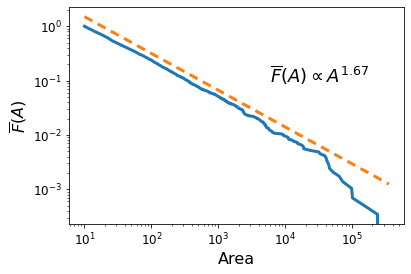

In [69]:
#To plot our "perfect" power law, we need to create a dummy variable that spans
# the same range as our data.
temp = np.linspace(min(df['area']), max(df['area'])+100000, 5000)
#Then we calculate the cumlative probability distribution using the function above. 
cpd = (temp/10)**-(alpha - 1)

plt.loglog(np.sort(df['area']), normed_CPD(df['area']), linewidth = 3)
plt.loglog(temp, 1.5*cpd, linestyle = '--', dashes = (3,2), linewidth = 3)
plt.xlabel('Area', fontsize = 16)
plt.ylabel('$\\overline{F}(A)$', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.annotate('$\\overline{F}(A) \propto A^{1.67} $', xy = (.6, .65), xycoords ='axes fraction', fontsize = 18)
plt.show()

## Now let's take a look at some of the geometric scaling relationships. 

In [70]:
df

,area,perimeter,depth
0,21,40,0.15
1,10,22,0.24
2,56,56,0.69
3,193,114,0.96
4,672,216,4.69
...,...,...,...
31319,211,130,1.15
31320,181,76,3.34
31321,461,168,2.80
31322,282,146,2.13


## Perimeter-area scaling relationships tell us how the perimeter of a shape grows with increasing area. 

## $$ P \propto A^{D/2} $$

## Euclidean shapes should have $D=1$, but fractal shapes take on values greater than 1 but less than 2. 

## Shapes with $D>1$ are fractals. See Mandelbrot (1967) for a good introduction to fractals. 

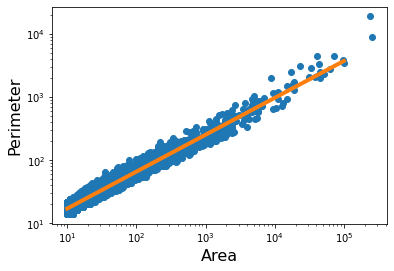

In [79]:
from scipy.stats import linregress

#Transform the data into log space to calculate the slope
m, yint, pval, rval, se = linregress(np.log10(df['area']), np.log10(df['perimeter']))

temp = np.linspace(10, 10**5, 10)

plt.loglog(df['area'], df['perimeter'], 'o')

#Don't forget to transform back into linear space to plot
plt.loglog(temp, 10**yint*temp**m, linewidth = 4)
plt.xlabel('Area', fontsize = 16)
plt.ylabel('Perimeter', fontsize = 16)
plt.show()

## How do we find the fractal dimension D? 

In [80]:
D = 2 * m
print(D)

1.1678322261286942


## Is there a scaling relationship for depth-area? Can you write it out mathematically? 

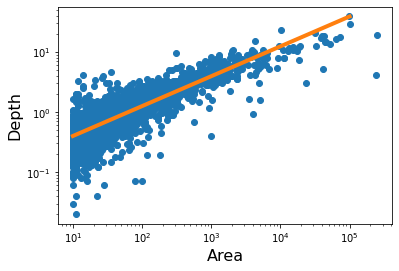

In [82]:
#Transform the data into log space to calculate the slope
m1, yint1, pval1, rval1, se1 = linregress(np.log10(df['area']), np.log10(df['depth']))

temp = np.linspace(10, 10**5, 10)

plt.loglog(df['area'], df['depth'], 'o')

#Don't forget to transform back into linear space to plot
plt.loglog(temp, 10**yint1*temp**m1, linewidth = 4)
plt.xlabel('Area', fontsize = 16)
plt.ylabel('Depth', fontsize = 16)
plt.show()

In [83]:
C = m1 * 2
print(C)

0.9948312151699251


# Let's take a look at the code I wrote to create figures for my soon-to-be-published manuscript.

In [84]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import seaborn as sns
from scipy.stats import linregress
import matplotlib.colors as colors
from scipy.stats import linregress

## Here are the functions I needed to perform my analyses. 

In [ ]:
def cumul_prob(data):
    data = np.sort(data)
    return np.array([(data[i] <= data).sum() for i in range(len(data))])

def normed_CPD(data):
    data = np.sort(data)
    prob = [(data[i] < data).sum() for i in range(len(data))]
    return prob / max(prob)

def calc_alpha(data, low_cutoff = None, high_cutoff = None):
    data = np.sort(data)
    if high_cutoff == None:
        high_cutoff = max(data)
    if low_cutoff == None:
        low_cutoff = min(data)
    data_cut = data[(data >= low_cutoff) & (data <= high_cutoff)]
    return 1 + len(data_cut) * (np.sum(np.log(data_cut / low_cutoff)))**-1

def calc_sigma(data, alpha, low_cutoff = None, high_cutoff = None):
    data = np.sort(data)
    if high_cutoff == None:
        high_cutoff = max(data)
    if low_cutoff == None:
        low_cutoff = min(data)
    data_cut = data[(data >= low_cutoff) & (data <= high_cutoff)]
    return (alpha - 1) / np.sqrt(len(data_cut))            

In [99]:
sinks_2019 = pd.read_csv('2019_Ngo-depressions_1m-borderdata.csv')

## I wanted to make a multiplot showing the results from all of my analyses. Since these analyses take a lot of steps, I first made a cell to complete all the calculations.

In [100]:
#Approximate amin, or define variable amin 
#alpha, amin, st, pval = powerlaw_bestFit(sinks_2019['area'], 10, 200, 10, 0.95)
alpha = 1.67
amin = 60
#Calculate probability densities
df = sinks_2019[sinks_2019['area'] >= 10]
data = df['area']
x2 = np.linspace(min(data), max(data)+100000, 5000)
cpd = (amin / x2)**(alpha - 1)
dataCPD = normed_CPD(data)

#Calculate perimeter-area scaling relationship
x3 = np.linspace(10, max(data), 10)
aranges = np.linspace(10, 10**5)
sqAreas = np.sqrt(data)
perimeters = df['perimeter']
restrict = df[df['area'] >= amin]
area_r = restrict['area']
perimeter_r = restrict['perimeter']
D, b, r, p, se = linregress(np.log10(np.sqrt(area_r)), np.log10(perimeter_r))
tempfrac = df.sample(frac=0.2, random_state = 1)
perimeters = tempfrac['perimeter']
areasfrac = tempfrac['area']

#Calculate depression depth kernel densities
slope_test = sinks_2019[sinks_2019['area'] >= 10]
areas = np.log10(slope_test['area'])
depth = np.log10(slope_test['_max'])
areamin = areas.min()
areamax = areas.max()
dmin = depth.min()
dmax = depth.max()
xd, yd = np.mgrid[areamin:areamax:200j, dmin:dmax:200j]
positionsd = np.vstack([xd.ravel(), yd.ravel()])
valuesd = np.vstack([areas, depth])
kerneld = stats.gaussian_kde(valuesd)
zd = np.reshape(kerneld(positionsd).T, yd.shape)
tempdepths = slope_test.sample(frac=0.2, random_state = 1)
areas = np.log10(tempdepths['area'])
depth = np.log10(tempdepths['_max'])

#Calculate area-depth scaling relationships
tempdf = slope_test
tempdf = tempdf[tempdf['area'] >= 50]
tempareas = np.log10(tempdf['area'])
tempdepth = np.log10(tempdf['_max'])
slope, yint, rval, pval, se = linregress(tempareas, tempdepth)

#Calculate perimeter slope kernel densities
slope_test = slope_test[slope_test['slope_medi'].notna()]
area = np.log10(slope_test['area'])
median = slope_test['slope_medi']
medMin = median.min()
medMax = median.max()
x, y = np.mgrid[areamin:areamax:200j, medMin:medMax:200j]
positions = np.vstack([x.ravel(), y.ravel()])
values = np.vstack([area, median])
kernel = stats.gaussian_kde(values)
z = np.reshape(kernel(positions).T, y.shape)
tempdensities = slope_test.sample(frac=0.2, random_state = 1)
area = np.log10(tempdensities['area'])
median = tempdensities['slope_medi']


2877 depressions


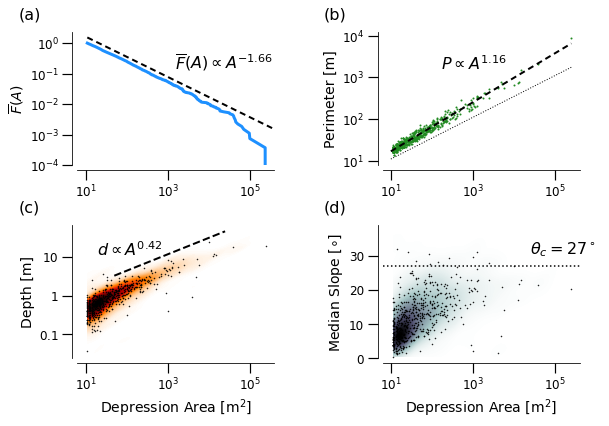

In [96]:
temp = np.linspace(np.log10(50), areamax-1, 100)

#CREATE A MULTIPLOT USING THE fig, ax = plt.subplots() NOTATION
fig, ax = plt.subplots(2,2, figsize = (9,6))

#Plot the depressions probability distribution
ax[0,0].loglog(np.sort(data), dataCPD, linewidth = 3, color = 'dodgerblue')
ax[0,0].loglog(x2, 0.5*cpd, linestyle = '--', dashes = (3,2), linewidth = 2, label = '$\\overline{F}(A) \propto A^{-1.66} $', color = 'k')
ax[0,0].legend(loc = (.4, .65), fontsize = 16, framealpha = 1, handlelength = 0, frameon = False)
ax[0,0].set_xlim([10**0.8, 10**5.6])
ax[0,0].set_ylabel('$\\overline{F}(A)$', fontsize = 14)
ax[0,0].get_xaxis().set_ticks([10**1, 10**3, 10**5])
ax[0,0].get_yaxis().set_ticks([10**-4, 10**-3, 10**-2, 10**-1, 10**0])
ax[0,0].tick_params('both', length = 10, width = 1.2, which = 'major', labelsize = 12)
ax[0,0].tick_params('both', length = 0, width = 1, which = 'minor')
ax[0,0].annotate('(a)', xy = (-.3,1.1), xycoords = 'axes fraction', fontsize = 16)

#Plot fractal dimensions (area-perimeter scaling relationship)
ax[0,1].loglog(areasfrac, perimeters, 'o', markersize = 1, alpha = 1, color = 'forestgreen')
ax[0,1].loglog(x3, 10**b*x3**(D/2), linestyle = '--', dashes = (3,2), linewidth = 2, label = '$P \propto A^{1.16}$', color = 'k')
ax[0,1].loglog(x3, 3.5*x3**0.5, linestyle = ':', linewidth = 1, color = 'k')
ax[0,1].legend(loc = (.2, .65), fontsize = 16, handlelength = 0, framealpha = 1, frameon = False)
ax[0,1].set_xlim([10**0.8, 10**5.6])
ax[0,1].set_ylabel('Perimeter [m]', fontsize = 14)
ax[0,1].get_xaxis().set_ticks([10**1, 10**3, 10**5])
ax[0,1].tick_params('both', length = 10, width = 1.2, which = 'major', labelsize = 12)
ax[0,1].tick_params('both', length = 0, width = 1, which = 'minor')
ax[0,1].annotate('(b)', xy = (-0.3,1.1), xycoords = 'axes fraction', fontsize = 16)

#Plot the kernel density estimation for the depth-area scaling relationship
ax[1,0].imshow(np.rot90(zd), cmap = 'gist_heat_r', extent = [areamin, areamax, dmin, dmax], aspect = 'auto', norm = colors.Normalize(vmin = zd.min(), vmax = np.percentile(zd, q = 100)))
ax[1,0].plot(areas, depth, 'ko', markersize = 0.5, alpha = 1)
ax[1,0].plot(temp, slope * temp + yint+0.5, '--', c = 'k', linewidth = 2, label = '$d \propto A^{0.42}$') 
ax[1,0].get_xaxis().set_ticks([1,3,5])
ax[1,0].get_yaxis().set_ticks([-1, 0, 1])
ax[1,0].set_xticklabels(["$10^1$","$10^3$","$10^5$"], fontsize = 12)
ax[1,0].set_yticklabels(["$0.1$","$1$","$10$"], fontsize = 12)
ax[1,0].set_xlim([0.8, 5.6])
ax[1,0].set_ylabel('Depth [m]', fontsize = 14)
ax[1,0].tick_params(labelsize = 12)
ax[1,0].tick_params('both', length = 10, width = 1.2, which = 'major')
ax[1,0].legend(loc = (0,0.7), handlelength = 0, fontsize = 16, frameon = False)
ax[1,0].set_xlabel('Depression Area [m$^2$]', fontsize = 14)
ax[1,0].annotate('(c)', xy = (-.3,1.1), xycoords = 'axes fraction', fontsize = 16)

#Plot perimeter slopes kernel density estimation
ax[1,1].imshow(np.rot90(z), cmap = 'bone_r', extent = [areamin, areamax, medMin, medMax], aspect = 'auto', norm = colors.Normalize(vmin = z.min(), vmax = np.percentile(z, q = 100)))
ax[1,1].plot(area, median, 'o', color = 'k', alpha = 1, markersize = 0.5)
ax[1,1].get_xaxis().set_ticks([1,3,5])
ax[1,1].set_ylim(0, 39)
ax[1,1].set_xticklabels(["$10^1$","$10^3$","$10^5$"], fontsize = 12)
ax[1,1].axhline(27, c = 'k', linestyle = ':', linewidth = 1.5, label = '$\\theta_{c} = 27^\circ$')
ax[1,1].set_xlim([0.8, 5.6])
ax[1,1].set_xlabel('Depression Area [m$^2$]', fontsize = 14)
ax[1,1].set_ylabel('Median Slope [$\circ$]', fontsize = 14)
ax[1,1].tick_params(labelsize = 12)
ax[1,1].tick_params('both', length = 10, width = 1.2, which = 'major')
ax[1,1].annotate('(d)', xy = (-.3,1.1), xycoords = 'axes fraction', fontsize = 16)
ax[1,1].legend(loc = (0.65, 0.7), handlelength = 0, fontsize = 16, frameon = False)
sns.despine(offset = [5,5])
fig.subplots_adjust(hspace = 0.45, wspace = 0.55)

plt.show()